In [ ]:
!git clone https://github.com/frgfm/torch-cam.git
!pip install -e torch-cam/.
!pip install grad-cam torchcam

fatal: destination path 'torch-cam' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/torch-cam
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl (887.5 MB)
  Building editable for torchcam (pyproject.toml) ... done
  Created wheel for torchcam: filename=torchcam-0.4.0.dev0-0.editable-py3-none-any.whl size=16036 sha256=9ae542f6de0400dcca42cb50d373fb4245e2b24a1c94b1d955ec5c2217d90f3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-0oklnd04/wheels/01/be/d9/bcd58c55f0941c76ea49be4bc6b7a29cbf46c236c38c1b3b98
Successfully built torchcam
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached grad-cam-1.4.6.tar.gz (7.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 120.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 66.2 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=fc60115531c68dea32ff52853d795fc3ca49cf9b7697a93df2840392e2316203
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam
  Attempting uninstall: torchvision
    Fou

In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This file is for creating a classifier. \\
The idea of code comes from: \\
https://www.youtube.com/watch?v=zFA8Cm13Xmk \\
https://www.bilibili.com/video/BV13P411K7Dq/?spm_id_from=333.999.top_right_bar_window_custom_collection.content.click&vd_source=d8ec61f040609385fff579504f83835d \\
https://youtu.be/r3cVTxa0u3E \\

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/pics/catdog'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/validation'
# test_dir = data_dir + '/test'

The function for calculate the mean and std
Idea from: https://youtu.be/ovZ_54IUSU4

In [ ]:
def get_mean_and_std(loader):
  mean = 0.0
  std = 0.0
  total_images_count = 0
  for images, _ in loader:
    image_count_in_a_batch = images.size(0)
    images = images.view(image_count_in_a_batch, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += image_count_in_a_batch

  mean /= total_images_count
  std /= total_images_count

  return mean, std

Preprocess data

In [ ]:
# Define transforms for those three datasets.
# 把这些不同大小的data给变成差不多的大小，使得图片会比较好被classifier识别
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# test_transforms = transforms.Compose([transforms.Resize(256),
#                                       transforms.CenterCrop(224),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406],
#                                                            [0.229, 0.224, 0.225])])

training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
# test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
# get_mean_and_std(train_loader)

In [ ]:
import json

with open('/content/drive/MyDrive/Colab Notebooks/classes_name.json', 'r') as f:
  classes_name = json.load(f)

print(len(classes_name))
print(classes_name)

2
{'1': 'cat', '2': 'dog'}


In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

In [ ]:
def train_nn(model, train_loader, valid_loader, criterion, optimizer, n_epochs):
  device = set_device()
  best_acc = 0

  for epoch in range(n_epochs):
    print("Epoch number %d" % (epoch + 1))
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0

    for data in train_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad()

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)

      loss = criterion(outputs, labels)

      loss.backward()\

      optimizer.step()

      running_loss += loss.item()
      running_correct += (labels==predicted).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.00 * running_correct / total

    print("     = Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
          % (running_correct, total, epoch_acc, epoch_loss))
    
    valid_dataset_acc = evaluate_model_on_test_set(model, valid_loader)

    if (valid_dataset_acc > best_acc):
      best_acc = valid_dataset_acc
      save_checkpoint(model, epoch, optimizer, best_acc)

  print("Finished")
  return model

In [ ]:
def evaluate_model_on_test_set(model, valid_loader):
  model.eval()
  predicted_correctly_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad():
    for data in valid_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      total += labels.size(0)

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)

      predicted_correctly_on_epoch += (predicted==labels).sum().item()

  epoch_acc = 100.00 * predicted_correctly_on_epoch / total
  print("     = Validation dataset. Got %d out of %d images correctly (%.3f%%)"
        % (predicted_correctly_on_epoch, total, epoch_acc))
  
  return epoch_acc

In [ ]:
def save_checkpoint(model, epoch, optimizer, best_acc):
  state = {
      'epoch' : epoch + 1,
      'model' : model.state_dict(),
      'best accuracy' : best_acc,
      'optimizer' : optimizer.state_dict(),
      'comments' : "Good model.",
  }
  torch.save(state, 'model_best_checkpoint.pth.tar')

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=True)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 2
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.0MB/s]


In [ ]:
train_nn(resnet18_model, train_loader, valid_loader, loss_fn, optimizer, n_epochs=22)

Epoch number 1


KeyboardInterrupt: ignored

Create a checkpoint for using in the future.

In [ ]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

In [ ]:
print(checkpoint['epoch'])
print(checkpoint['comments'])
print(checkpoint['best accuracy'])

In [ ]:
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 2
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, 'best_model.pth')

Start testing for a picture which is not exists in training and validation dataset. 

In [ ]:
classes = [
    "cat",
    "dog",
]

In [ ]:
model = torch.load('best_model.pth')

In [ ]:
image_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [ ]:
import PIL.Image as Image
def classify(model, image_transforms, image_path, classes):
  model = model.eval()
  image = Image.open(image_path)
  image = image_transforms(image).float()
  image = image.unsqueeze(0)

  output = model(image)
  _, predicted = torch.max(output.data, 1)

  print(classes[predicted.item()])

In [ ]:
classify(model, image_transforms, "/content/drive/MyDrive/Colab Notebooks/pics/catdog/test/cats/cat.1500.jpg", classes)

# **CAM**
Idea from: https://github.com/TommyZihao/Train_Custom_Dataset/tree/main

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


导入训练好的Model

In [ ]:
from torchvision.models import resnet18
model = resnet18(pretrained=True).eval().to(device)
# model = torch.load('best_model.pth')
# model = model.eval().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


导入可解释性分析方法

In [ ]:
from torchcam.methods import SmoothGradCAMpp 
# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM

cam_extractor = SmoothGradCAMpp(model)

对图像进行预处理

In [ ]:
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

运行图像分类预测

In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/pics/catdog/test/cats/cat.1500.jpg'

In [ ]:
img_pil = Image.open(img_path)
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理

In [ ]:
pred_logits = model(input_tensor)
pred_id = torch.topk(pred_logits, 1)[1].detach().cpu().numpy().squeeze().item()

In [ ]:
pred_id

283

生成可解释性分析热力图

In [ ]:
activation_map = cam_extractor(pred_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()

In [ ]:
activation_map.shape

(7, 7)

可视化

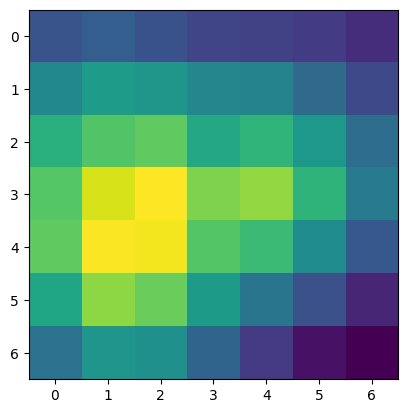

In [ ]:
plt.imshow(activation_map)
plt.show()

In [ ]:
from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)

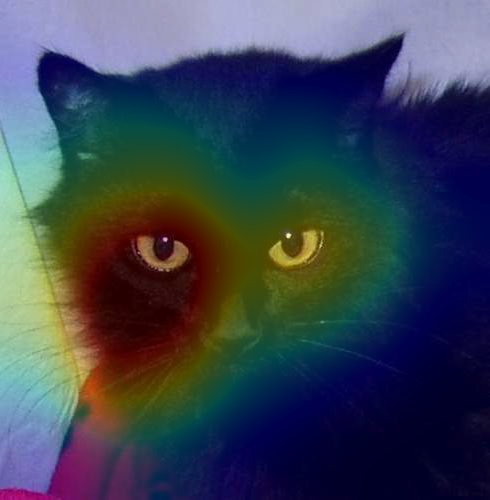

In [ ]:
result

# **Grad CAM**

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

预处理

In [ ]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(512),
                                     # transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

载入测试图像

In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/pics/catdog/test/cats/cat.1672.jpg'

img_pil = Image.open(img_path)
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
input_tensor.shape

torch.Size([1, 3, 512, 648])

指定分析的类别

In [ ]:
# targets = None
targets = [ClassifierOutputTarget(283)]

分析模型结构，确定待分析的层

In [ ]:
model.layer4[-1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
model.layer1[0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

选择可解释性分析方法

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMElementWise, GradCAMPlusPlus, XGradCAM, AblationCAM, ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad
# Grad-CAM
from pytorch_grad_cam import GradCAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

生成CAM热力图

In [ ]:
with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    cam_map = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)[0]

可视化CAM热力图

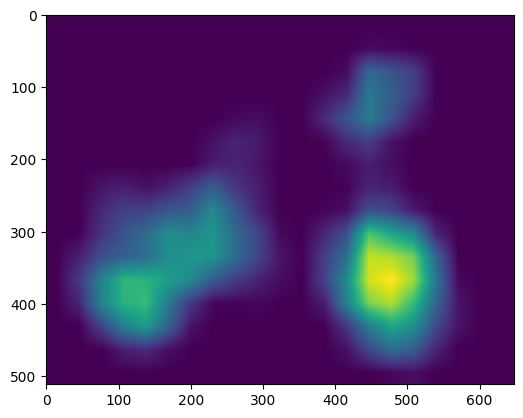

In [ ]:
cam_map.shape
plt.imshow(cam_map)
plt.show()

In [ ]:
import torchcam
from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(cam_map), alpha=0.7) # alpha越小，原图越淡

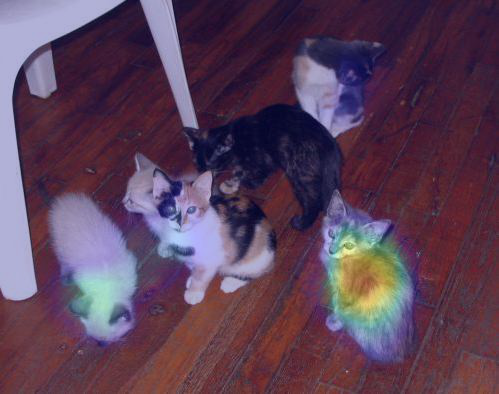

In [ ]:
result